 ### 1st Place LGB Model(public:0.470, private:0.502)について

https://www.kaggle.com/pureheart/1st-place-lgb-model-public-0-470-private-0-502

特徴量は２２４？

テストを2017-03-12〜2017-04-22に設定。

意味わからないとこ全般

 ### ①ホリデーフラグ
```
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)
```
dayofweekで、月曜日が0、日曜日が6

「金土日＋休暇」にフラグしている。

 ### ②日付差分
```
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days
```
おいおい関数の中で出てくる。差分の日付を出す理由はなぜ？

 ### ③end_date,start_date
```
label_end_date = date_add_days(end_date, n_day)
label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
```
関数の中で毎回日数を区切っている？（end_dateとstart_dateが出てくる）


 ### ④曜日ごとの平均
```
def get_store_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['visitors2'] = data_temp['visitors']
    result = None
    for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
        result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
        result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result
```
曜日ごとのお店の平均、中央値等を出している。（0.9〜0.999の重み付けして乗算している？）

end_dateからstart_dateに変わるとn_dayがマイナスされている理由は？

 ### ⑤ジャンルと曜日
```
def get_genre_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result
```
ジャンルと曜日は使っていたが

```
def get_genre_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight'].agg({'genre_dow_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
    result['genre_dow_exp_mean{}'.format(n_day)] = result['genre_dow_exp_mean{}'.format(n_day)]/result['genre_dow_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result
```
さらに平均と合計に重みをかけて特徴量を追加している？

 ### ⑥start_date
```
train_feat = pd.DataFrame()
start_date = '2017-03-12'
for i in range(58):
    train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
    train_feat = pd.concat([train_feat,train_feat_sub])
for i in range(1,6):
    train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])
test_feat = make_feats(date_add_days(start_date, 42),39)
```
3/12の意味は？

-n_dayでstart_dateを3/12より前にしている？なんのため？

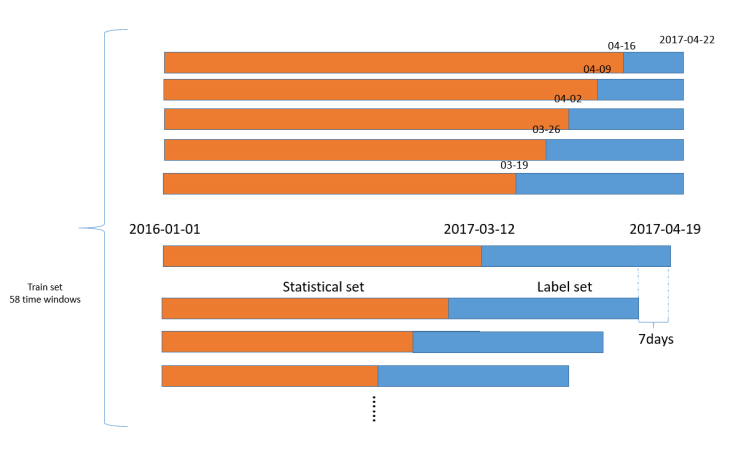

In [8]:
from IPython.display import Image, display_png
display_png(Image('5a8bfe5495d7e.png'))